In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Custom functions
from utils import *
from backtester import *

In [2]:
%load_ext autoreload
%autoreload 2

## ARIMA forecasting [DAILY]

In [3]:
# Load
corn_raw = pd.read_csv('data/corn.csv', header = 2)

# Process
df = process_data(corn_raw, 'CORN', start_date = '2000-01-01', end_date='2020-01-01') 
#df

In [10]:
# plt.figure(figsize=(16,9))
# plt.plot(df.Date, df.CORN)
# plt.show()

In [5]:
# Take log values
df.loc[:,"CORN_log"] = np.log(df.CORN)

# Take first order differencing
difference_order = 1
df["CORN_log_diff"] = df.CORN_log.diff(periods=difference_order)
df["CORN_diff"] = df.CORN.diff(periods=difference_order)

# Drop first row(s) used up in the differencing (they are NaNs for lags < order) 
df = df.drop(index=range(difference_order))

# Reset Index
df = df.reset_index(drop = True)

## First order differencing of log prices

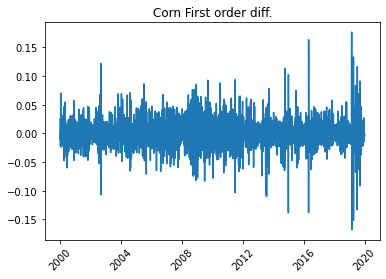

In [6]:
plt.plot(df.Date, df.CORN_log_diff)
plt.title("Corn First order diff.")
plt.xticks(rotation=45)
plt.show()

## ACF:

In [ ]:
acf_coeffs, acf_conf_interval = acf(df.CORN_log_diff, nlags=100, alpha = 0.01)

# We don't care about lag=0, so get rid of those 
acf_coeffs = acf_coeffs[1:]
acf_conf_interval = acf_conf_interval[1:,:]

# Subtract off mean to get error bar value
acf_error_bars = np.abs(acf_conf_interval[:,0] - acf_coeffs)
acf_sig_level = np.average(acf_error_bars)

In [ ]:
acf_xs = np.arange(1,len(acf_coeffs)+1, 1)
plt.figure(figsize=(12,9))
#plt.bar(x=acf_xs, height=acf_coeffs, yerr=acf_error_bars)
plt.bar(x=acf_xs, height=acf_coeffs)
plt.axhline(y=acf_sig_level, color='r', linestyle='--')
plt.axhline(y=(-1*acf_sig_level), color='r', linestyle='--')
plt.title("ACF of first differenced log prices + 99% conf interval")
plt.show()

#### Appear to be some statistically significant lags at the 99% confidence level
#### Might be significant... but absolute value of the correlation is still tiny

## PACF:

In [ ]:
pacf_coeffs, pacf_conf_interval = pacf(df.CORN_log_diff, nlags=100, alpha = 0.01)

# We don't care about lag=0, so get rid of those 
pacf_coeffs = pacf_coeffs[1:]
pacf_conf_interval = pacf_conf_interval[1:,:]

# Subtract off mean to get error bar value
pacf_error_bars = np.abs(pacf_conf_interval[:,0] - pacf_coeffs)
pacf_sig_level = np.average(pacf_error_bars)

In [ ]:
pacf_xs = np.arange(1,len(pacf_coeffs)+1, 1)
plt.figure(figsize=(12,9))
#plt.bar(x=pacf_xs, height=pacf_coeffs, yerr=pacf_error_bars)
plt.bar(x=pacf_xs, height=pacf_coeffs)
plt.axhline(y=pacf_sig_level, color='r', linestyle='--')
plt.axhline(y=(-1*pacf_sig_level), color='r', linestyle='--')
plt.title("PACF of first differenced log prices + 99% conf interval")
plt.show()

## MA(1) on first difference

AIC: -24661.114082898268
BIC: -24648.078896675393


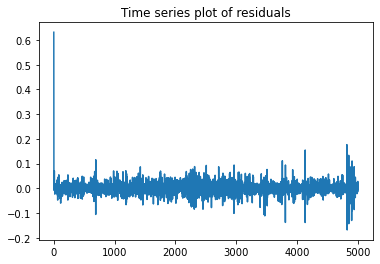

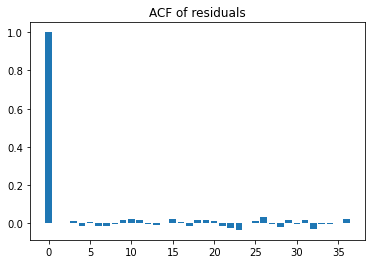

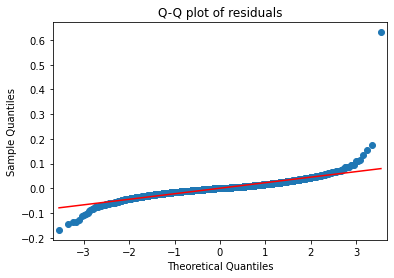

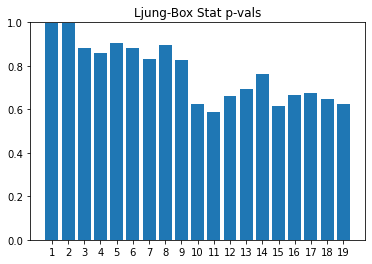

In [15]:
model = ARIMA(df.CORN_log, order=(0,1,1))
results = model.fit()    

print("AIC: " + str(results.aic))
print("BIC: " + str(results.bic))
    

plt.plot(results.resid)
plt.title("Time series plot of residuals")
plt.show()

acf_list = acf(results.resid)
plt.bar(np.arange(0,len(acf_list), 1), acf_list)
plt.title("ACF of residuals"); plt.show()
plt.show()


fig = qqplot(results.resid, line  = 's')
plt.title("Q-Q plot of residuals")
plt.show()

LB_stat, LB_stat_p_val = acorr_ljungbox(results.resid, lags=np.arange(1,20,1), return_df = False)
#print("Ljung-Box Statistic: " + str(LB_stat))
#print("Ljung-Box Statistic p-val: " + str(LB_stat_p_val))
plt.bar(np.arange(1,20,1), LB_stat_p_val)
plt.xticks(ticks = np.arange(1,20,1))
plt.ylim([0,1])
plt.title("Ljung-Box Stat p-vals")
plt.show()

## AR(1) on first difference

AIC: -24661.109610429845
BIC: -24648.07442420697


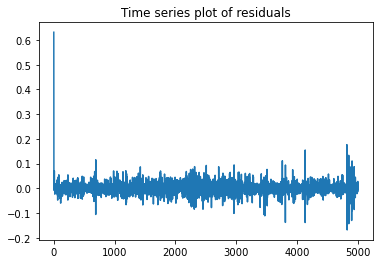

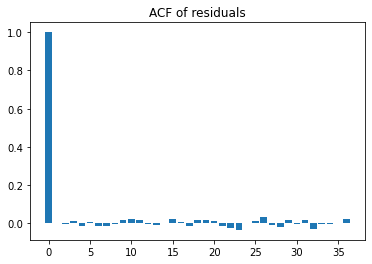

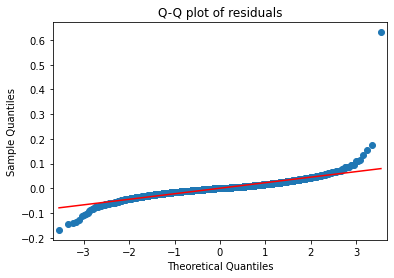

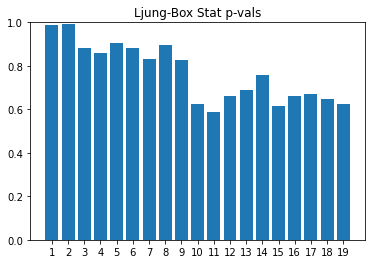

In [16]:
model = ARIMA(df.CORN_log, order=(1,1,0))
results = model.fit()    

print("AIC: " + str(results.aic))
print("BIC: " + str(results.bic))
    

plt.plot(results.resid)
plt.title("Time series plot of residuals")
plt.show()

acf_list = acf(results.resid)
plt.bar(np.arange(0,len(acf_list), 1), acf_list)
plt.title("ACF of residuals"); plt.show()
plt.show()


fig = qqplot(results.resid, line  = 's')
plt.title("Q-Q plot of residuals")
plt.show()

LB_stat, LB_stat_p_val = acorr_ljungbox(results.resid, lags=np.arange(1,20,1), return_df = False)
#print("Ljung-Box Statistic: " + str(LB_stat))
#print("Ljung-Box Statistic p-val: " + str(LB_stat_p_val))
plt.bar(np.arange(1,20,1), LB_stat_p_val)
plt.xticks(ticks = np.arange(1,20,1))
plt.ylim([0,1])
plt.title("Ljung-Box Stat p-vals")
plt.show()

## ARIMA(p,1,q)

In [ ]:

list_of_aics = []
list_of_bics = []
list_of_info = []

for p in np.arange(0,10,1):
    for q in np.arange(0,10,1):
        model = ARIMA(df.CORN_log, order=(p,1,q))
        results = model.fit()   
        
        myinfo = "Params: p=" + str(p) + " q=" + str(q)
        #print(myinfo)
        #print("AIC: " + str(results.aic))
        #print("BIC: " + str(results.bic))
        list_of_info += [myinfo]
        list_of_aics += [results.aic]
        list_of_bics += [results.bic]
        
        
minaic = np.argmin(list_of_aics)
print("min aic: " + list_of_info[minaic])
print("aic: " + str(list_of_aics[minaic]))
        
minbic = np.argmin(list_of_bics)
print("min bic: " + list_of_info[minbic])
print("bic: " + str(list_of_bics[minbic]))


# plt.plot(results.resid)
# plt.title("Time series plot of residuals")
# plt.show()

# acf_list = acf(results.resid)
# plt.bar(np.arange(0,len(acf_list), 1), acf_list)
# plt.title("ACF of residuals"); plt.show()
# plt.show()


# fig = qqplot(results.resid, line  = 's')
# plt.title("Q-Q plot of residuals")
# plt.show()

# LB_stat, LB_stat_p_val = acorr_ljungbox(results.resid, lags=np.arange(1,20,1), return_df = False)
# #print("Ljung-Box Statistic: " + str(LB_stat))
# #print("Ljung-Box Statistic p-val: " + str(LB_stat_p_val))
# plt.bar(np.arange(1,20,1), LB_stat_p_val)
# plt.xticks(ticks = np.arange(1,20,1))
# plt.ylim([0,1])
# plt.title("Ljung-Box Stat p-vals")
# plt.show()

# Simulation
### One week ahead forecasting

In [17]:
# Rolling window
training_days = 60

true_values = []
predicted_values = []
dates = []

start = 0

## THIS WILL TAKE A LONG TIME
end = int((df.shape[0] - training_days) / 5) # 5 trading days in a week

for i in range(start, end):
    training_df = df.iloc[(5*i):(5*i)+training_days]
    test_df = df.iloc[(5*i)+training_days+5] # One week ahead
    
    # ARIMA on log prices
    model = ARIMA(training_df.CORN_log, order=(0,1,1))
    results = model.fit()
    
    # Step ahead 5 days
    one_week_ahead_forecast = results.get_forecast(5).summary_frame().iloc[-1,0]
    
    true_values.append(test_df.CORN_log)
    predicted_values.append(one_week_ahead_forecast)
    dates.append(test_df.Date)

/Users/matthewjohnson/opt/anaconda3/envs/stats207/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/matthewjohnson/opt/anaconda3/envs/stats207/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/matthewjohnson/opt/anaconda3/envs/stats207/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/matthewjohnson/opt/anaconda3/envs/stats207/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

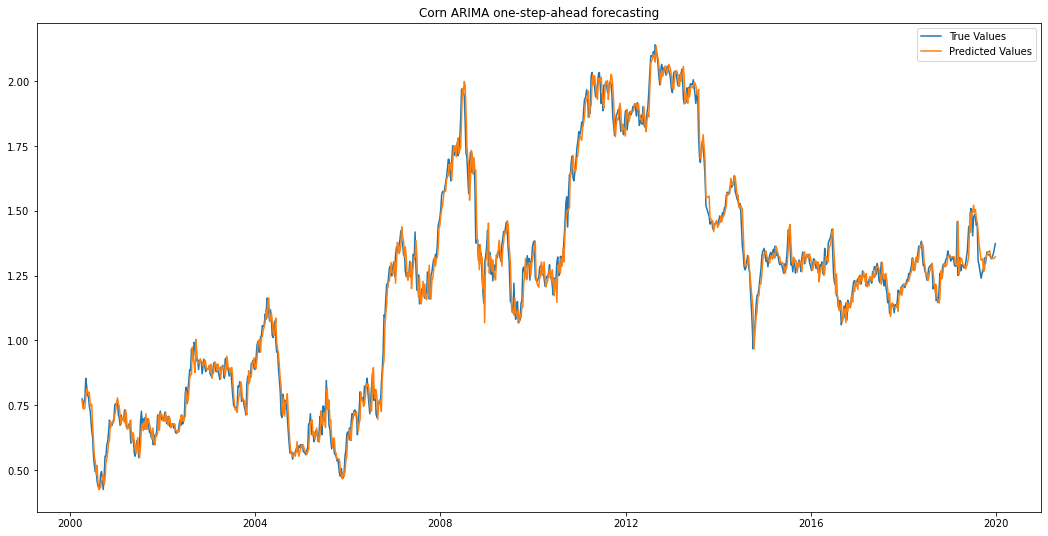

In [22]:
plt.figure(figsize=(18,9))
plt.plot(dates, true_values, dates, predicted_values)
plt.legend(["True Values", "Predicted Values"])
plt.title("Corn ARIMA one-step-ahead forecasting")
plt.show()

1.2266714806633638


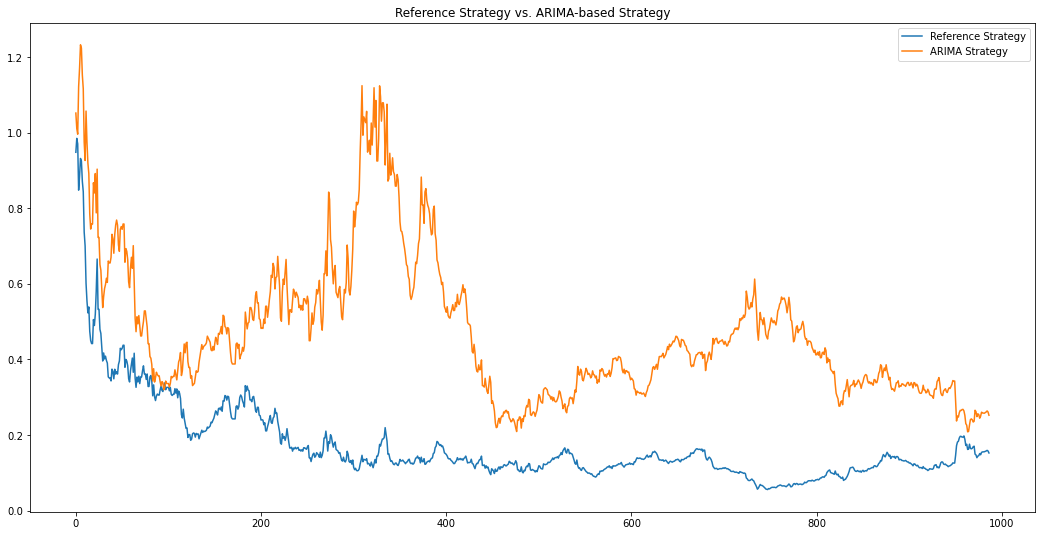

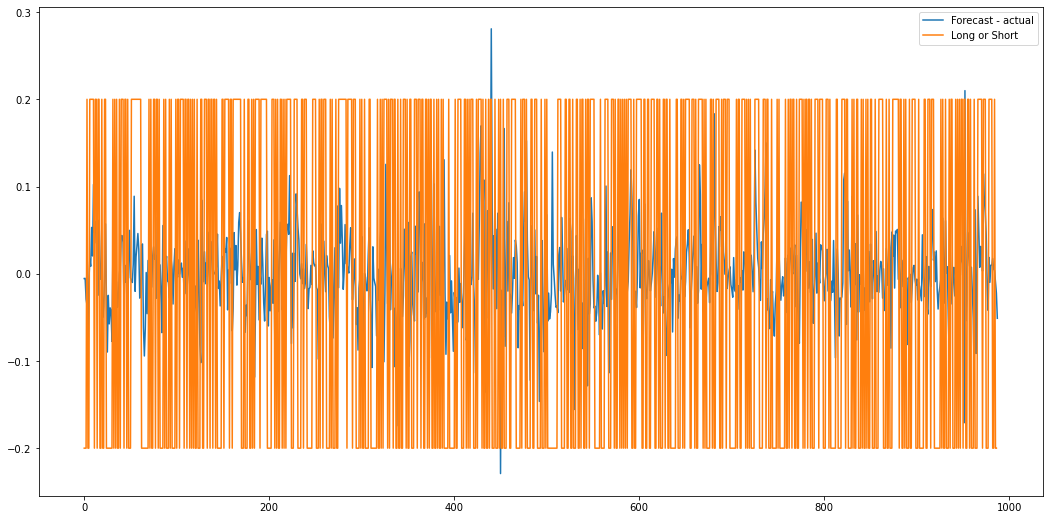

In [23]:
strategy, long_only = backtest(forecast_for_each_day=predicted_values, price_series=true_values)

# Multi-variate version

### Turn into ARIMAX by incorporating other commodities? Dependent: Corn, Independent: Corn, Wheat, Soybean, 

predicted_values

In [21]:
mylist = [1,2,3,4,5]

mylist[0:3]
mylist[3]

4